# Disclaimer

This can only properly be run on a heavy duty PC

In [2]:
training_rows_to_read = 1000000 # This needs to be 15000000

# Imports

In [3]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta
import numpy as np
import pandas as pd

Preprocessing successfully imported.


In [4]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
training_data = preprocessing.read_data(rows_to_read = training_rows_to_read)["train"]
print(training_data.columns)

Reading 1000000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Run the basic preprocessing steps

In [5]:
training_data = preprocessing.basic_preprocessing(training_data)

Finished parse_datetime_columns
Finished create_delivery_calendar_days
Finished clean_zip_codes


In [6]:
training_data["delivery_calendar_days"].describe()

count    1000000.000000
mean           4.750261
std            3.118329
min         -117.000000
25%            3.000000
50%            4.000000
75%            5.000000
max          214.000000
Name: delivery_calendar_days, dtype: float64

In [7]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 378601
declared_handling_days : 12
acceptance_scan_timestamp : 450084
shipment_method_id : 21
shipping_fee : 3574
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 31216
buyer_zip : 32986
category_id : 33
item_price : 16245
quantity : 58
payment_datetime : 988627
delivery_date : 720
weight : 637
weight_units : 2
package_size : 5
record_number : 1000000
delivery_calendar_days : 129
cleaned_item_zip : 27157
cleaned_buyer_zip : 31623
distance_between_pincodes : 962601


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [8]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : "numerical",
    "carrier_max_estimate"   : "numerical",
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
    "cleaned_item_zip" : 30743,
    "cleaned_buyer_zip" : 34876,
    "distance_between_pincodes" : "numerical",
}

In [9]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (1000000, 23)
training_data.shape after :  (1000000, 80)


In [10]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Outlier Handling

In [11]:
columns_to_prune = { # Percentage of outliers to drop in each column both top and bottom.
    "shipping_fee" : 0.01,
    "item_price" : 0.001,
    "distance_between_pincodes" : 0.001,
    "quantity" : 0.01,
    "weight" : 0.01,
    "delivery_calendar_days" : 0.01, 
    # This is obviously problematic. Maybe we should have a model that handles outliers in the target
}

### Dropping outliers rows

In [12]:
def remove_outliers(data, columns_to_prune):# This is fundamentally flawed because the thresholds to be pruned should have been calculated earlier not after pruning one or two coloumns.
    for col in columns_to_prune.keys():
        print("col : ", col)
        min_and_max = data[col].quantile([columns_to_prune[col], (1-columns_to_prune[col])]).values
        all_rows_to_drop = np.append(np.where(data[col] > min_and_max[1])[0], np.where(data[col] < min_and_max[0])[0])
#         print("all_rows_to_drop : ", all_rows_to_drop)
        print("all_rows_to_drop.shape : ", all_rows_to_drop.shape)
#         return all_rows_to_drop
        data.drop(all_rows_to_drop, inplace=True)
        print("After dropping rows shape is :", data.shape)
        data.reset_index(inplace = True, drop = True)
#         data[col] = np.where(data[col] > upper_limit, upper_limit, data[col])
#         data[col] = np.where(data[col] < lower_limit, lower_limit, data[col])
    return data

In [13]:
# training_data = remove_outliers(data = training_data, columns_to_prune=columns_to_prune)

In [14]:
columns_to_squeeze = {
    "shipping_fee",
    "item_price",
    "distance_between_pincodes",
    "quantity",
    "weight",
}

Replacting the outliers with median

In [34]:
def replaceOutliersWithMedian(data, columns):
    for col in columns:
        sorted(data[col])
        Q1, Q3 = data[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        median = np.median(data[col])
        data[col] = np.where(data[col] > upper_limit, median, data[col])
        data[col] = np.where(data[col] < lower_limit, median, data[col])
    return data

### Squeezing the outliers

In [14]:
def squeeze_outlier_with_interquantile_range(data, columns):
    for col in columns:
        sorted(data[col])
        Q1, Q3 = data[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        data[col] = np.where(data[col] > upper_limit, upper_limit, data[col])
        data[col] = np.where(data[col] < lower_limit, lower_limit, data[col])
    return data

In [35]:
backup_training_data = training_data.copy()

training_data = replaceOutliersWithMedian(data = training_data, columns=columns_to_squeeze)

In [36]:
training_data["shipping_fee"].describe()

count    1000000.000000
mean           1.426131
std            2.394511
min           -0.250000
25%            0.000000
50%            0.000000
75%            3.000000
max            8.750000
Name: shipping_fee, dtype: float64

In [37]:
backup_training_data["shipping_fee"].describe()

count    1000000.000000
mean           1.674328
std            2.710413
min           -0.250000
25%            0.000000
50%            0.000000
75%            3.500000
max           10.000000
Name: shipping_fee, dtype: float64

### Results and observations

Choosing a custom percentage to crop off for each column will almost certainlycome in handy.

The obvious problem is to detect outliers in delivery_calendar_days.

Loss is reduced after we drop outliers from all the column not only delivery_calendar_days.

Not sure how to deal with that yet. But one thing to keep in mind is that since the evaluation is not a squared metric, we can be allowed to have a small section of the data be wildly off. If the evaluation was squared then this small section would have had a huge impact on the loss. 

## Running a gradient boosted decision tree model

In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Custom evaluation function

In [39]:
def customLossFunctionEval(y_true, y_pred):
    residual = (y_true - y_pred).astype(np.float32)
    loss = np.where(residual < 0, 0.4 * (residual), 0.6 * (residual))
#     return np.mean(loss)
    return "Custom Loss Function", np.mean(loss), False

In [40]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((670000, 69), (330000, 69), (670000,), (330000,))

In [41]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=(x_test,y_test),
          verbose=10,eval_metric=customLossFunctionEval)# This loss needs to mirror the loss that Ebay is using.

/home/monisha/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's l2: 8.60158	valid_0's Custom Loss Function: 0.159965
[20]	valid_0's l2: 8.42176	valid_0's Custom Loss Function: 0.157385
[30]	valid_0's l2: 8.38014	valid_0's Custom Loss Function: 0.156587
[40]	valid_0's l2: 8.36792	valid_0's Custom Loss Function: 0.156267
[50]	valid_0's l2: 8.36529	valid_0's Custom Loss Function: 0.156029
[60]	valid_0's l2: 8.36333	valid_0's Custom Loss Function: 0.155922
[70]	valid_0's l2: 8.35897	valid_0's Custom Loss Function: 0.155816
[80]	valid_0's l2: 8.35547	valid_0's Custom Loss Function: 0.15571
[90]	valid_0's l2: 8.35506	valid_0's Custom Loss Function: 0.155658
[100]	valid_0's l2: 8.35338	valid_0's Custom Loss Function: 0.155601


LGBMRegressor(max_depth=-5, random_state=42)

# Evaluating the model

In [42]:
model_test_outputs = model.predict(x_test)

In [26]:
pd.Series(model_test_outputs).describe()

count    330000.000000
mean          4.747877
std           1.234543
min           2.564713
25%           4.215959
50%           4.515410
75%           5.028782
max          74.187882
dtype: float64

In [27]:
customLossFunctionEval(y_true = y_test, y_pred = model_test_outputs)

('Custom Loss Function', 0.15579115, False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

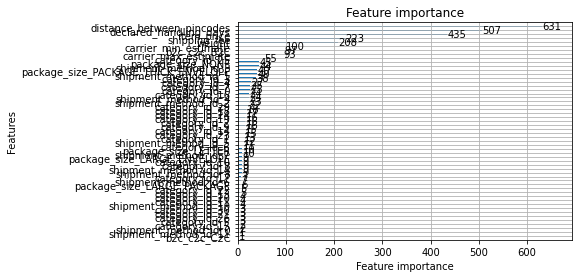

In [28]:
lgb.plot_importance(model)

In [29]:
feature_importances = {}

for importance, feature in zip(model.feature_importances_, model.feature_name_):
    feature_importances[feature] = importance

feature_importances

{'declared_handling_days': 507,
 'shipping_fee': 223,
 'carrier_min_estimate': 100,
 'carrier_max_estimate': 93,
 'item_price': 435,
 'quantity': 0,
 'weight': 208,
 'distance_between_pincodes': 631,
 'b2c_c2c_B2C': 97,
 'b2c_c2c_C2C': 1,
 'shipment_method_id_0': 2,
 'shipment_method_id_3': 44,
 'shipment_method_id_1': 40,
 'shipment_method_id_5': 12,
 'shipment_method_id_2': 23,
 'shipment_method_id_6': 7,
 'shipment_method_id_8': 9,
 'shipment_method_id_10': 4,
 'shipment_method_id_7': 10,
 'shipment_method_id_4': 24,
 'shipment_method_id_13': 0,
 'shipment_method_id_14': 9,
 'shipment_method_id_9': 0,
 'shipment_method_id_11': 1,
 'shipment_method_id_12': 0,
 'shipment_method_id_15': 0,
 'shipment_method_id_24': 0,
 'shipment_method_id_17': 0,
 'shipment_method_id_18': 0,
 'shipment_method_id_19': 0,
 'shipment_method_id_16': 0,
 'category_id_13': 5,
 'category_id_0': 25,
 'category_id_1': 13,
 'category_id_3': 38,
 'category_id_11': 4,
 'category_id_18': 18,
 'category_id_12': 0,
 

In [30]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.1905
Testing accuracy 0.1455


In [31]:
# training_data["model_outputs"] = model.predict(training_data[cols_to_use])

In [32]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [33]:
raise

RuntimeError: No active exception to reraise

In [ ]:
del training_data
quiz_data = preprocessing.read_data(rows_to_read = 10000)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


In [ ]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

In [ ]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [ ]:
output_columns_name = "predicted_delivery_date"

In [ ]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [ ]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [ ]:
import pandas as pd

In [ ]:
submission = pd.read_csv("./results/result_2021-12-19 00:30:37.tsv", sep='\t', header = None)

In [ ]:
submission